In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# from tools import *

In [4]:
# -*- coding: utf-8 -*-

def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),256)

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y


def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex//2))
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex//2))
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex//4)),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),int(nbex//4)),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(int(nbex//2))))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y


# 1. Données et classifieur bayésien naïf

## Etude du jeu de données artificielles

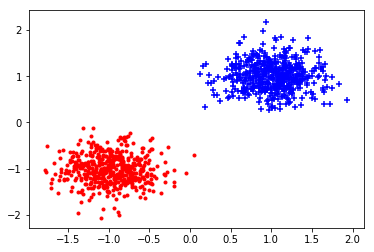

In [5]:
# Visualisation des données
data0, y0 = gen_arti(data_type=0)
plot_data(data0, y0)

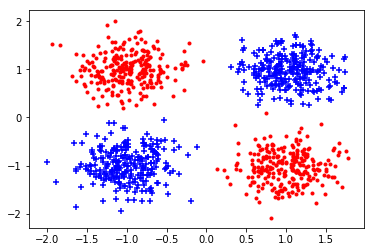

In [6]:
data1, y1 = gen_arti(data_type=1)
plot_data(data1, y1)

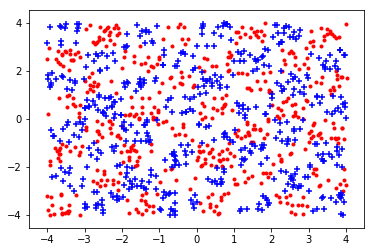

In [7]:
data2, y2 = gen_arti(data_type=2)
plot_data(data2, y2)

## Etude du jeu de données réelles

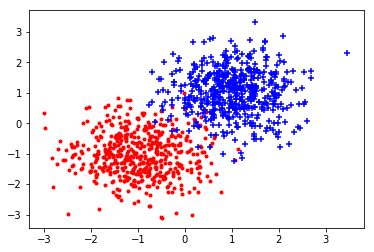

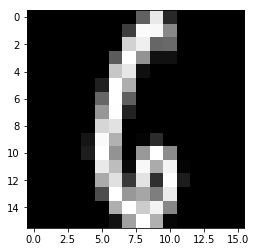

In [8]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")


### Donnees artificielles
plt.ion()
xgentrain,ygentrain = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)
xgentest,ygentest = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)
plt.figure()
plot_data(xgentrain,ygentrain)

### Donnees reelles
plt.figure()
xuspstrain,yuspstrain = load_usps("USPS_train.txt")
xuspstest,yuspstest = load_usps("USPS_test.txt")
x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
x06test,y06test = get_usps([0,6],xuspstest,yuspstest)
show_usps(x06train[0])


A mons avis, il est a priori plus simple de classifier 2 chiffres aux formes très différentes que de classifier un chiffre contre tous les autres.
En effet, il existe des paires de chiffres qui vont potentiellement être difficiles à différencier. Ce sont les paires qui ont des formes communes, comme peuvent l'être par exemple:
- 0 et 8
- 8 et 6
- 1 et 7
- 5 et 6

## Classifieur Bayésien

In [9]:
class Bayes:
    """Pour l'instant marche uniquement pour de la classification binaire"""
    def __init__(self, apriori=[1/2, 1/2]):
        self.p_y = apriori.copy()
        
        pass
    
    def predict(self,data):
        func = np.array([self.log_proba(data, ind) for ind, y in enumerate(self.nb_labels)]).T
        y_predict = np.argmax(func, axis=1)
        np.place(y_predict, y_predict==0, -1)
        return y_predict
                        
    def log_proba(self, x, label):
        mu, std = self.mu[label], self.std[label]
        logproba = -(x-mu)**2 + 2*(std**2)
        logproba = np.log(self.p_y[label]) + logproba
        logproba = np.sum(logproba, axis=1)
        return logproba
        
    def fit(self,data,labels, apriori):
        self.mu = []
        self.std = []
        self.nb_labels = np.unique(labels)
        for y in self.nb_labels:
            self.mu.append(np.mean(data[labels==y], axis=0))
            self.std.append(np.std(data[labels==y], axis=0))
        self.mu = np.array(self.mu)
        self.std = np.array(self.std)
        assert(len(self.mu)==len(self.nb_labels))
        pass
    
    def score(self,data,labels):
        return (self.predict(data)==labels).mean()
    
    


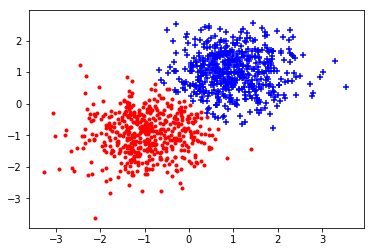

In [10]:
bay = Bayes()
bay.fit(xgentrain, ygentrain)
predict = bay.predict(xgentest)
plot_data(xgentest, predict)

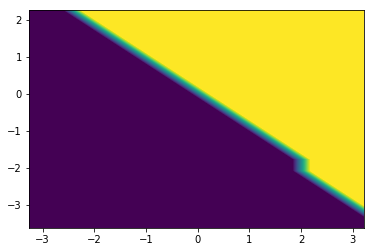

In [12]:
plot_frontiere(xgentest, bay.predict)

In [16]:
xuspstrain.shape

(7291, 256)

In [13]:
# Classification appliquée à des données réelles
bay = Bayes()
bay.fit(xuspstrain, yuspstrain)
y_pred = bay.predict()

IndexError: list index out of range

In [19]:
yuspstest[0]

9

** FINIR DERNIER QUESTION. POUR CELA PERMETTRE CLASSIFICATION MULTICLASSES **

# Descente de gradient

In [39]:
def optimize(func, dfunc, xinit=1, eps=0.1, max_iter=200):
    converged = False
    ind = 0
    xt = xinit 
    ft = func(xinit) 
    dt = dfunc(xinit)
    X, F, D = [xt], [ft], [dt]
    for i in range(max_iter):
        xt = xt - eps*dt
        ft, dt = func(xt), dfunc(xt)
        X.append(xt)
        F.append(ft)
        D.append(dt)
    return np.array(X), np.array(F), np.array(D)

Test sur la fonction $f:x \rightarrow x \cos (x)$

In [40]:
f = lambda x : x*np.cos(x)
df = lambda x : np.cos(x) - x*np.sin(x)

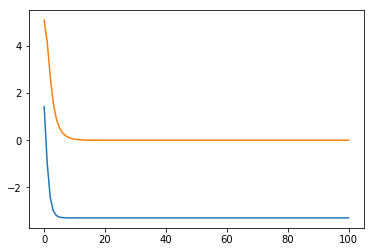

In [69]:
# First we want to plot the evolution of f and df in function of the number of iterations
xs, fs, ds = optimize(f, df, xinit=5, eps=0.1, max_iter=100)

n_iter = np.arange(len(xs))
plt.figure()
plt.plot(n_iter, fs)
plt.plot(n_iter, ds)

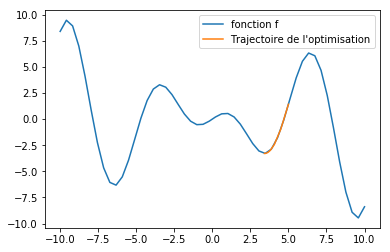

In [70]:
grid = np.linspace(-10, 10)
fgrid = [f(xi) for xi in grid]
plt.figure()
plt.plot(grid, fgrid, label='fonction f')
plt.plot(xs, fs, label="Trajectoire de l'optimisation")
plt.legend()

/home/pierre/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


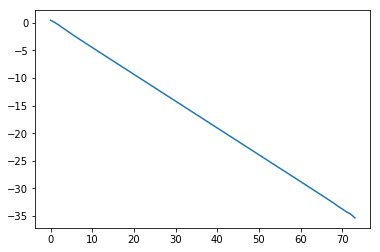

In [73]:
xs = xs.reshape(-1,1)
xhat = xs[-1] 
ts = np.arange(len(xs))
curb = np.log(np.linalg.norm(xs - xhat, axis=1))
plt.figure()
plt.plot(ts, curb)

Test sur la fonction $f:x \rightarrow 100(x_2 - x_1^2)^2 + (1 - x_1)^2$ (2D)

In [77]:
func = lambda x: 100*(x[1] - (x[0]**2))**2 + (1-x[0])**2
dfunc = lambda x: [2*x[0]*(-200*(x[1]-(x[0]**2)) - (1-x[0])), 200*(x[1]-(x[0]**2))]

In [76]:
10**2

100

**COMPLETER ET FINIR PARTIE**

# Applications : Classification plug-in et Régression logistique


Calcul des gradients de coûts:
- Pour la classification plug-in.
Le coût s'écrit $L(w, X)= ||f_w(X) - Y||^2 = \sum_i (f_w(X)_i-y_i)^2$
$$\frac{\partial L}{\partial w_j} = 2\sum_i X_{nj}(f_w(X)_i - y_i)=2X_j^T(f_w(X)-y)$$
où X_j est le j ème vecteur colonne de X.
D'où enfin:
$$\nabla L = 2 X^T(f_w(X)-y)$$
- Pour la classification à l'aide de régression logistique:
$$L(w,X) = \sum_i \log(1 + e^{-y_if_w(x^i)})$$
Donc
$$\frac{\partial L}{\partial w_j}$$


Remarque : penser à TOUJOURS TRANSFORMER EN MATRICES
data = data.reshape(len(label), -1)
label = labeL.reshape(-1, 1)

In [194]:
# MSE AND grad of MSE for plugin classification
def mse(w, data, label):
    data = data.reshape((len(label),-1))
    label = label.reshape(-1)
    vec = np.dot(data, w) - label
    return (vec**2).mean()

def grad_mse(w, data, label):
    data = data.reshape((len(label),-1))
    label = label.reshape(-1)
    vec = np.dot(data, w) - label
    return np.dot(2*data.T, vec) / len(label)
    

In [195]:
# Tests
data = xgentest
label = ygentest
n,d = np.shape(xgentest)
w = np.ones(d)
data = data.reshape((len(label),-1))
label = label.reshape(-1)

print(mse(w, data, label))
print(grad_mse(w, data, label))

2.0390327469
[ 3.0673248   3.08609654]


In [196]:
def reglog(w, data, label):
    data = data.reshape((len(label),-1))
    label = label.reshape(-1)
    
    reg = np.dot(data, w)
    costs = np.log(1+np.exp(np.multiply(-label, reg)))
    return np.sum(costs) / len(label)

def grad_reglog(w, data, label):
    
    return 

In [197]:
# Tests
data = xgentest
label = ygentest
n,d = np.shape(xgentest)
w = np.ones(d)
data = data.reshape((len(label),-1))
label = label.reshape(-1)
reg = np.dot(data, w)
cost = np.log(1+np.exp(np.multiply(-label, reg)))
np.sum(cost)
print(reglog(w, data, label))
# print(grad_mse(w, data, label))

0.175340173706


In [ ]:
n, d = np.shape(data)
datab = np.ones((n,d+1))
datab[:, 1:] = data